<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP (Part 3 - Preprocessing and Modelling)

## 1. Import libraries and datasets

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

# Set viewing options
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('max_colwidth', 200)

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/clean_dataset_modelling.csv')

In [3]:
df.head()

,all_text,subreddit
0,"Hello everyone, what are the different methods and algorithms for model aggregation in federated learning? Can anyone help with any resource/articles...?",datascience
1,"Is it worth starting Data Science as an Individual Contributor? For context, I've worked with data for 10 years but mostly in analysis/reporting roles. I've recently moved into a people manager po...",datascience
2,Imputing features like ratings and rankings Can any one tell how to deal with null values for rankings and ratings features in a movie revenue dataset. I was thinking of imputing with mean values ...,datascience
3,"Best way to deal with missing/empty data in a small dataset Hi. Potentially a simple, recurring questions here..I have a small dataset with around 10k rows. It has several columns, two of which ha...",datascience
4,Curious how many of us work with data streaming or data batch What are your thoughts on those two?(,datascience


## 2. Preprocessing

#### 2.1 Convert text data to lowercase

Python treats upper case and lower case separately, hence all the text data will be converted to lower case for a more streamlined interpretation by Python. 

In [4]:
df['all_text'] = df['all_text'].str.lower()

#### 2.2 Expand contracted words

Words such as "don't" and "can't" are short forms for "do not" and "can not". These words will be expanded for uniformity, as well as not end up breaking up the words when special characters are removed in subsequent steps.

In [5]:
# define function to expand contracted words
# credits to: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490%22%22%22

def decontracted(phrase):
    
    # standardize the apostrophe so the function can recognize all the contracted words
    phrase = re.sub(r"\’", "\'", phrase)
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

In [6]:
df['all_text'] = df['all_text'].apply(decontracted)

#### 2.3 Remove special characters and numbers

Special characters and numbers are removed as they do not add value, and may affect the model's accuracy.

In [7]:
def remove_special_characters(text):
    
    # replace special characters with an empty space
    # replacing with empty space prevents unwanted joining of words post-removal
    text = re.sub(r'[\W]+', ' ', text)
    text = re.sub(r'[\_]', ' ', text) 
    
    # remove double spacing resulting from previous creation of double-spacing
    text.replace('  ', ' ')
    
    # remove words containing numerics 
    text = re.sub(r'\S*\d\S*', '', text)
    
    return text

In [8]:
df['all_text'] = df['all_text'].apply(remove_special_characters)

#### 2.4 Lemmatizing text data

There are words in our texts that are different forms of a same word. There are methods to return such words to their root form so that they will be treated as the same word, mainly by lemmatization and stemming. 

Lemmatization will be utilized in this case as it reduces text by matching them with a language dictionary, whereas stemming is a more crude method by removing prefixes and suffixes.

In [9]:
# define function to lemmatize text data

def lemmatize_text(text):
    # instantiate RegexpTokenizer and WordNetLemmatizer
    tokenizer = RegexpTokenizer('\w+')
    lemmatizer = WordNetLemmatizer()
    
    # list of stopwords
    stopword = stopwords.words('english')
    
    # tokenize text data
    tokens = tokenizer.tokenize(text)
    lemmatized_tokens = []
    
    # lemmatize only words that are not stopwords so they are still recognized as stopwords
    for i in tokens:
        if i not in stopword:
            i = lemmatizer.lemmatize(i)
        lemmatized_tokens.append(i)
    
    # combine words into text data again
    lemmatized_text = " ".join(lemmatized_tokens)
    
    return lemmatized_text

In [10]:
df['all_text'] = df['all_text'].apply(lemmatize_text)

#### 2.5 Convert target feature column to numerical values

The 'subreddit' column will be converted to a numerical column for subsequent modelling. 0 represents Data Science whereas 1 represents Digital Marketing.

In [11]:
df['subreddit'] = df['subreddit'].map({'datascience': 0, 'DigitalMarketing': 1})

In [110]:
df.head()

,all_text,subreddit
0,hello everyone what are the different method a...,0
1,is it worth starting data science as an indivi...,0
2,imputing feature like rating and ranking can a...,0
3,best way to deal with missing empty data in a ...,0
4,curious how many of u work with data streaming...,0


#### 2.6 Define X and y variables

In [13]:
# Define X and y variables
X = df['all_text']
y = df['subreddit']

#### 2.7 Split data into training and testing sets

In [14]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Baseline model

The baseline model accuracy is established as a basis for performance comparison with our more complex models. This is established by guessing the majority class in the dataset.

In [15]:
y.value_counts(normalize=True)

0    0.507144
1    0.492856
Name: subreddit, dtype: float64

Accuracy score of Baseline model: 50.71%

## 4. Modelling

For this project, we will explore using different models to classify our text data. The following models will be used and evaluated based on their performance:
- Multinomial Naive Bayes (MultinomialNB)
- Random Forest Classifier
- Support Vector Machine

Before modelling our data, we would first need to convert our text data into a structured, numeric X dataframe as a 'bag-of-words'. We will do this separately with 2 methods, CountVectorizer and TF-IDF Vectorizer. CountVectorizer creates a vector for each individual word and calculates the occurrence for each word. TF-IDF Vectorizer works similarly, but gives a higher weightage to words that do not occur frequently in the documents of the corpus.

The performance of each model and the choice of vectorization was evaluated by comparing the accuracy score, and a confusion matrix is plotted for each model for an overview of its performance.

## 5. Multinomial Naive Bayes model 

The Multinomial Naive Bayes (MultinomialNB) model is a classification model that calculates the probabilities of a text/document belonging to either class using Bayes theorem. 

#### 5.1 Multinomial Naive Bayes and CountVectorizer

Before modelling, we vectorize our text data into a bag of words for fitting into our models using CountVectorizer. We create a pipeline and gridsearch through the CountVectorizer hyperparameters and score with MultinomialNB which is a very computationally cheap.

Besides obtaining the accuracy scores of our model, we also establish the optimal hyperparameters for vectorizing our text data with CountVectorizer.

In [81]:
# define function to pull accuracy score of training and testing dataset for each model
def get_metrics(modelname, model, X_train, X_test):
    print(modelname)
    print(u'\u2500' * 30)
    print(f"Accuracy score of training set: {round(100* model.score(X_train, y_train),2)}%")
    print(f"Accuracy score of testing set: {round(100* model.score(X_test, y_test),2)}%")
    print(u'\u2500' * 30)    
    return plot_confusion_matrix(model, X_test,y_test)

In [17]:
# instantiate CountVectorizer + MultinomialNB pipeline
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# define pipeline parameters
pipe_nb_cvec_params = {
    'cvec__max_features': [2_000, 3_000],
    'cvec__min_df': [2, 5, 8],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

# instantiate GridSearchCV
grid_nb_cvec = GridSearchCV(estimator=pipe_nb_cvec,
                      param_grid=pipe_nb_cvec_params,
                      cv=5)

In [18]:
# fit GridSearchCV object to data
grid_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000],
                         'cvec__min_df': [2, 5, 8],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

Multinomial Naive Bayes Model with CountVectorizer
──────────────────────────────
Accuracy score of training set: 94.75%
Accuracy score of testing set: 94.9%
──────────────────────────────


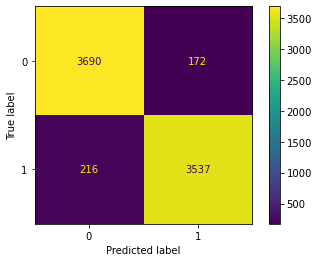

In [82]:
# print accuracy score for train and test set
get_metrics('Multinomial Naive Bayes Model with CountVectorizer', grid_nb_cvec, X_train, X_test)

In [20]:
# print out best hyperparameters
grid_nb_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 1)}

The text data are vectorized with CountVectorizer based on the optimal hyperparameters established by the pipeline, and saved as 'X_train_cvec' and 'X_test_cvec' to save on computational bandwidth when fitted on subsequent models.

In [37]:
#transform X_train and X_test set with CountVectorizer with optimized hyperparameters
cvec = CountVectorizer(stop_words='english',
                       max_features=3000,
                       max_df=0.9,
                       min_df=5,
                       ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#### 5.2 Multinomial Naive Bayes and TF-IDF Vectorizer

The text data was then vectorized with TF-IDF Vectorizer. We created a pipeline and gridsearched through the TF-IDF Vectorizer hyperparameters and scored with the MultinomialNB model.

Again, we obtained the accuracy scores of the MultinomialNB model, and established the optimal hyperparameters for vectorizing our text data with TF-IDF Vectorizer.

In [22]:
# instantiate TfidfVectorizer + MultinomialNB pipeline
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# define pipeline parameters
pipe_nb_tvec_params = {
    'tvec__max_features': [2_000, 3_000],
    'tvec__min_df': [2, 5, 8],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

# instantiate GridSearchCV
grid_nb_tvec = GridSearchCV(estimator=pipe_nb_tvec,
                      param_grid=pipe_nb_tvec_params,
                      cv=5)

In [23]:
# fit GridSearchCV object to data
grid_nb_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000],
                         'tvec__min_df': [2, 5, 8],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

Multinomial Naive Bayes Model with TF-IDF Vectorizer
──────────────────────────────
Accuracy score of training set: 94.63%
Accuracy score of testing set: 94.72%
──────────────────────────────


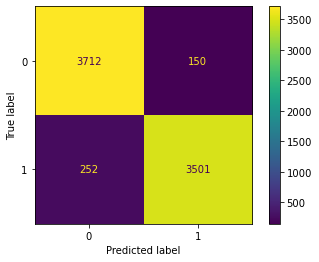

In [83]:
# print accuracy score for train and test set
get_metrics('Multinomial Naive Bayes Model with TF-IDF Vectorizer', grid_nb_tvec, X_train, X_test)

In [25]:
# print out best parameters
grid_nb_tvec.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

The text data are also vectorized with TF-IDF Vectorizer based on the optimal hyperparameters established by the pipeline, and saved as 'X_train_tvec' and 'X_test_tvec' to save on computational bandwidth when fitted on subsequent models.

In [38]:
#transform X_train and X_test set with TfidfVectorizer with optimized parameters
tvec = TfidfVectorizer(stop_words='english',
                       max_features=3000,
                       max_df=0.9,
                       min_df=5,
                       ngram_range=(1,2))

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

## 6. Random Forest model

The random forest model is another supervised learning model consisting of a number of individual decision trees using a random subset of features at each split in the learning process.

We will run our text data with the random forest model and gridsearch across a few hyperparameters and evaluate the performance of the random forest model with both vectorization methods.

#### 6.1 Random Forest and CountVectorizer

In [39]:
# define GridSearchCV parameters
rf_params = {'n_estimators': [200, 500, 800],
             'max_depth': [5, 10, 15]
}

# instantiate GridSearchCV
grid_rf_cvec = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                      param_grid=rf_params,
                      cv=5)

In [40]:
# fit GridSearchCV object to data
grid_rf_cvec.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [200, 500, 800]})

In [41]:
# print out best parameters
grid_rf_cvec.best_params_

{'max_depth': 15, 'n_estimators': 500}

Random Forest Model with CountVectorizer
──────────────────────────────
Accuracy score of training set: 91.4%
Accuracy score of testing set: 91.1%
──────────────────────────────


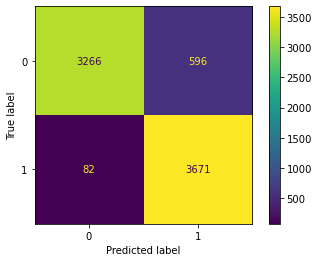

In [84]:
# print accuracy score for train and test set
get_metrics('Random Forest Model with CountVectorizer', grid_rf_cvec, X_train_cvec, X_test_cvec)

#### 6.2 Random Forest and TF-IDF Vectorizer 

In [43]:
# instantiate GridSearchCV
grid_rf_tvec = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                      param_grid=rf_params,
                      cv=5)

In [44]:
# fit GridSearchCV object to data
grid_rf_tvec.fit(X_train_tvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [200, 500, 800]})

In [45]:
# print out best parameters
grid_rf_tvec.best_params_

{'max_depth': 15, 'n_estimators': 800}

Random Forest Model with TF-IDF Vectorizer
──────────────────────────────
Accuracy score of training set: 91.21%
Accuracy score of testing set: 90.69%
──────────────────────────────


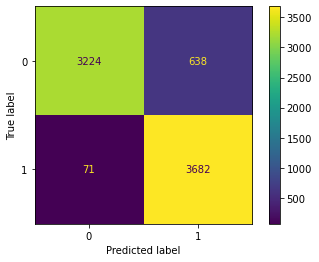

In [85]:
# print accuracy score for train and test set
get_metrics('Random Forest Model with TF-IDF Vectorizer', grid_rf_tvec, X_train_tvec, X_test_tvec)

## 7. Support Vector Machine model

The support vector machines are classification models that identifies a hyperplane in an N-dimensional space and utilizes 'support vectors' which are data points that maximizes the margin of the decision boundaries.

We will again break down the text data with both vectorization methods and compare the performance of the support vector machine model while gridsearching across various hyperparameters and evaluate the model's performance. 

#### 7.1 Support Vector Machines and CountVectorizer

In [47]:
# define GridSearchCV parameters
svc_params = {'C': [0.05, 0.1, 1, 5],
              'kernel': ['linear','poly','rbf'],
              'degree': [2,3]
}

# instantiate GridSearchCV
grid_svc_cvec = GridSearchCV(estimator=SVC(random_state=42),
                      param_grid=svc_params,
                      cv=5)

In [48]:
# fit GridSearchCV object to data
grid_svc_cvec.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.05, 0.1, 1, 5], 'degree': [2, 3],
                         'kernel': ['linear', 'poly', 'rbf']})

In [49]:
# print out best parameters
grid_svc_cvec.best_params_

{'C': 0.1, 'degree': 2, 'kernel': 'linear'}

Support Vector Machine Model with CountVectorizer
──────────────────────────────
Accuracy score of training set: 96.14%
Accuracy score of testing set: 94.42%
──────────────────────────────


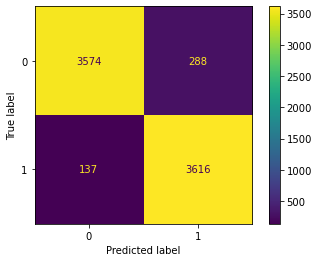

In [86]:
# print accuracy score for train and test set
get_metrics('Support Vector Machine Model with CountVectorizer', grid_svc_cvec, X_train_cvec, X_test_cvec)

#### 7.2 Support Vector Machines with TF-IDF Vectorizer

In [51]:
# instantiate GridSearchCV
grid_svc_tvec = GridSearchCV(estimator=SVC(random_state=42),
                      param_grid=svc_params,
                      cv=5)

In [52]:
# fit GridSearchCV object to data
grid_svc_tvec.fit(X_train_tvec, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.05, 0.1, 1, 5], 'degree': [2, 3],
                         'kernel': ['linear', 'poly', 'rbf']})

In [53]:
# print out best parameters
grid_svc_tvec.best_params_

{'C': 1, 'degree': 2, 'kernel': 'rbf'}

Support Vector Machine Model with TF-IDF Vectorizer
──────────────────────────────
Accuracy score of training set: 98.55%
Accuracy score of testing set: 95.23%
──────────────────────────────


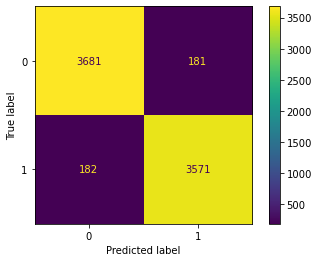

In [87]:
# print accuracy score for train and test set
get_metrics('Support Vector Machine Model with TF-IDF Vectorizer', grid_svc_tvec, X_train_tvec, X_test_tvec)

## 8. Results and Discussion

#### 8.1 Summary of model performance

The table below is the compilation of the accuracy scores for the training and testing data from running each of the models and either of the vectorization method. 


|Model|Train Accuracy Score|Test Accuracy Score|
|---|---|---|
|Baseline model|50.71%|
|Multinomial Naive Bayes and CountVectorizer|94.75%|94.90%|
|Multinomial Naive Bayes and TF-IDF Vectorizer|94.63%|94.72%|
|Random Forest and CountVectorizer|91.40%|91.10%|
|Random Forest and TF-IDF Vectorizer|91.21%|90.69%|
|Support Vector Machines and CountVectorizer|96.14%|94.42%|
|Support Vector Machines and TF-IDF Vectorizer|98.55%|95.23%|

#### 8.2 Metrics

Accuracy score was chosen to be the evaluation metric for comparing model performances instead of other metrics such as precision, recall and specificity. Our goal of the project was to evaluate if our model is able to classify text data correctly, and the accuracy score represents the percentage of posts that were classified correctly to either r/datascience or r/digitalmarketing.

#### 8.3 Production model

Based on the accuracy scores obtained from the various models, our choice of production model is the Support Vector Machine model using TF-IDF vectorization. While all the models performed reasonably well and outperformed the baseline model by a huge margin, the support vector machines model obtained the highest test accuracy score of 95.23% when the text data was vectorized with using the TF-IDF method. Although there was a slight overfitting issue with this model, it still managed to achieve the highest test accuracy score, and the difference in accuracy scores between training and testing sets was within reasonable range. 

Theory-wise, support vector machines are known to perform well with high-dimensional datasets, as in the case of our dataset comprising of large amounts of text data. The model could also potentially be computationally cheap as it utilizes the 'kernel trick' in which the model allows us to operate in the original feature space while doing the computation in a higher dimensional space.

However, there is a downside. Support vector machines get much more computationally expensive as the dataset gets larger(more post submissions) as compared to the other models. Therefore for larger datasets, it may be wise to consider other models such as the Multinomial Naive Bayes which is computationally cheap without forgoing much performance.

#### 8.4 Misclassified texts

In [88]:
preds = grid_svc_tvec.predict(X_test_tvec)

In [103]:
pred_df = pd.DataFrame(data=X_test)
pred_df['actual'] = y_test
pred_df['predicted'] = preds
misclassified_df = pred_df[pred_df['actual'] != pred_df['predicted']]

In [105]:
misclassified_df

,all_text,actual,predicted
6229,guy can you please help with this question posting the link for the same i am sorry i was unable to type the question again here its too long amp gt any help is appreciated thanks in advance,0,1
29615,update amp aarrr framework,1,0
12449,are gmos bad for your health are gmos bad for your health gmos are widely used and praised for their improvement in modern medicine however we proudly label food and agricultural practice that are...,0,1
992,our ai for engineer teacher has recommended book for the course i am just overwhelmed after going through their content i am attaching the content page screenshot of the two book i feel would be m...,0,1
18346,where to begin,0,1
10093,trigonometry qubitbit hologram,0,1
29659,why seos are going to miss the structured data testing tool,1,0
26708,what do you think about adworld conference is it worth the did any one of you attended the conference last year how was it like did you learn anything brilliant,1,0
22118,get daily guidance to help you cope with anxiety and uncertainty built yourself with ai science human design and nasa data try it for free,1,0
25640,qr code hello does anyone know if how it is possible to track scan of qr code let is say i have a code on a card and i want to see how many people are scanning additionally do you know of any more...,1,0


We generated the list of posts in which our model had classifed incorrectly. From the table above, there was a significant number of posts that were rather short in the count of words. As such the model may have insufficient text information to classify correctly. Also, some of the submissions contained nonsensical text and/or only contained generic words which may have limited the model's predictive ability.

## 9. Conclusions and Recommendations

In summary, we recommend to utilize the Support Vector Machines model to classify if a particular post belonged to either subreddit, with our model achieving a respectable accuracy of 95.23%. This meant that for every 10,000 posts run through our model, we expect the model to predict 9523 posts correctly that they belonged to a particular subreddit.

Our model allows us to classify whether a particular text belonged to either subreddit/topic, so that the instructonal team would not have to manually read every single post to understand the current educational trend. However, merely building the model is insufficient to achieve our project goal, as we are still unable to understand the current trend. Some additional work could be done to achieve this, such as collecting posts and/or comments within a particular time period(eg. 3 month period), and establishing if there were more submissions belonging to either subreddit, as well as to conduct a sentiment analysis to analyze user's perspective towards a particular topic.